In [10]:
import os
import pandas as pd
import numpy as np
import yaml
import logging
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utilities.utilities import read_ac_data, add_gdp_cdd_data
from utilities.plotting import plot_exposure_contour

In [11]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

if not os.path.exists('Figures/exposure_function') :
    os.makedirs('Figures/exposure_function')

In [12]:
# Read the air conditioning data from the EIA and GDL

# EIA data of AC access from 2018
ac_data_eia = read_ac_data(config['ac_historical_file_iea'], 2018, skip=3)

# GDL data from multiple years
ac_data_gdl = read_ac_data(config['ac_historical_file_gdl'])

# Read OECD data
ac_data_oecd = read_ac_data(config['ac_historical_file_oecd'], 2011)

# Merge the two dataframes
ac_data = pd.concat([ac_data_oecd, ac_data_gdl, ac_data_eia])

ac_data = add_gdp_cdd_data(ac_data, config)

ac_data["GDP"] = pd.to_numeric(ac_data["GDP"], errors='coerce')

# If there are multiple entries for the same country, only keep the latest one
ac_data = ac_data.drop_duplicates('ISO3', keep='last')
ac_data = ac_data.dropna()

# Save the data to a csv file
ac_data.to_csv("air_conditioning_data.csv")

# Prepare xdata as a tuple of CDD and GDP, ydata as AC
xdata = (ac_data["CDD"]/1000., ac_data["GDP"]/100000.)
ydata = ac_data["AC"]


In [13]:
# AC access function with values from paper
def ac_access_paper(xdata):
    cdd, gdp = xdata
    return (1. - 0.949*np.exp(-0.00187 * cdd)) * (1 / (1 + np.exp(4.152) * np.exp(-0.237 * gdp/1000.)))

# Functional form of AC access function
def ac_access(xdata, a, b, c):
    cdd, gdp = xdata
    return (1. - np.exp(-a * cdd)) * (1 / (1 + np.exp(b) * np.exp(-c * gdp)))

def ac_access_combined_exp(xdata, a, b, c):
    cdd, gdp = xdata
    return (1. - np.exp(-a * ((cdd)**b * (gdp)**c)))

In [14]:
# Calculate the R^2 and RMSE value
def calc_r2_rmse(ydata, ymodel):
    ss_res = np.sum((ydata - ymodel) ** 2)
    ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    rmse = np.sqrt(ss_res / len(ydata))
    print ("R2 value: ", r2)
    print ("RMSE value: ", rmse)
    return r2, rmse

In [15]:
# Plot AC access data vs model
def plot_ac_access(ydata, ymodel, color, title, filename):
    plt.figure()
    plt.scatter(ydata, ymodel, color=color)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # Both axes in log scale
    plt.xscale('log')
    plt.yscale('log')
    # Set the limits of the axes
    plt.xlim([0.001, 1])
    plt.ylim([0.001, 1])
    # Add labels
    plt.xlabel("AC access data")
    plt.ylabel("AC access model")
    plt.title(title)
    plt.savefig("Figures/exposure_function/{0}.png".format(filename))

R2 value:  0.2674010378060383
RMSE value:  0.1980627775755193


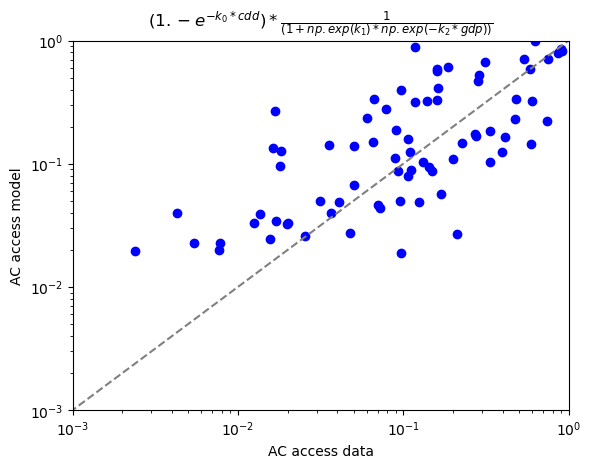

In [16]:
# Paper model with parameter values from paper
calc_r2_rmse(ydata, ac_access_paper((ac_data["CDD"], ac_data["GDP"])))
plot_ac_access(ydata, ac_access_paper((ac_data["CDD"], ac_data["GDP"])), "blue",r"$(1. - e^{-k_0 * cdd}) * \frac{1}{(1 + np.exp(k_1) * np.exp(-k_2 * gdp))}$", "ac_access_paper")

[4.36775516 2.57860165 8.21963776]
R2 value:  0.5801283342285852
RMSE value:  0.14994362280556955


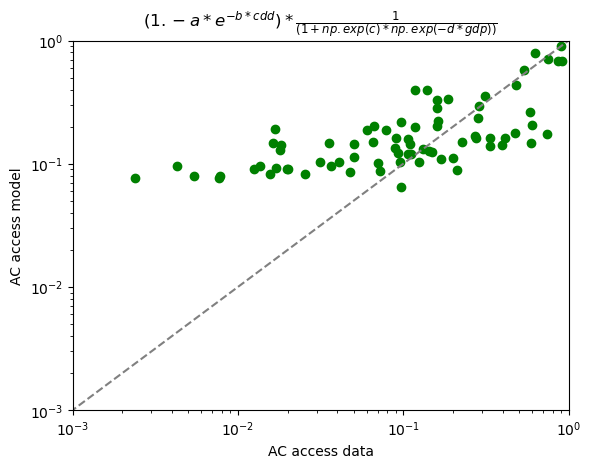

In [17]:
# Fit the paper function to new data
popt, pcov = curve_fit(ac_access, xdata, ydata)

print(popt)

# Calculate the R^2 and RMSE value
calc_r2_rmse(ydata, ac_access(xdata, *popt))
# Plot the AC access data vs model
plot_ac_access(ydata, ac_access(xdata, *popt), "green", r"$(1. - a*e^{-b * cdd}) * \frac{1}{(1 + np.exp(c) * np.exp(-d * gdp))}$", "ac_access_paper_new_fit")

# Save the parameters to a pickle file to use for plotting
with open('exposure_function_params_exponential.pkl', 'wb') as f:
    pickle.dump({'cdd_scale': popt[0], 'alpha': popt[1], 'k': popt[2]}, f)

[2.6878754  0.29301719 1.29450614]
R2 value:  0.5053624078052015
RMSE value:  0.1627471062769852


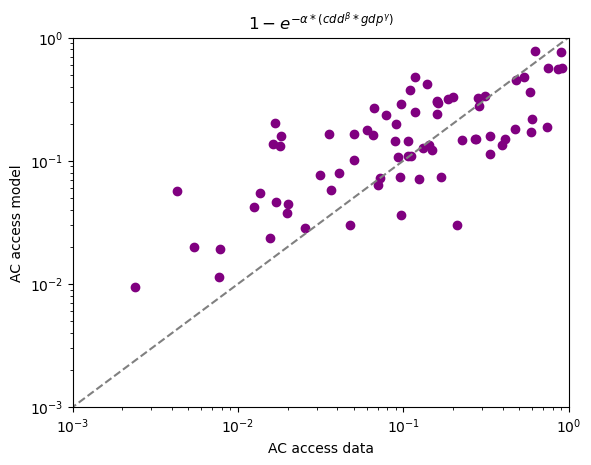

In [18]:
# Alternative fit function
ydata = (ac_data["AC"])
popt_comb, pcov_comb = curve_fit(ac_access_combined_exp, xdata, ydata)

print(popt_comb)
# Calculate the R^2 and RMSE value
calc_r2_rmse(ydata, ac_access_combined_exp(xdata, *popt_comb))
# Plot the AC access data vs model
plot_ac_access(ydata, ac_access_combined_exp(xdata, *popt_comb), "purple", r"$1 - e^{-\alpha * (cdd^{\beta} * gdp^{\gamma})}$", "ac_access_combined_exp")

with open('exposure_function_params_combined_exponential.pkl', 'wb') as f:
    pickle.dump({'cdd_scale': popt_comb[0], 'alpha': popt_comb[1], 'k': popt_comb[2]}, f)